In [ ]:
!pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Meteostat library and dependencies**

In [ ]:
from datetime import datetime
from meteostat import Hourly
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
# warnings.filterwarnings('ignore')

**Importing Data From Meteostat**

In [ ]:
# Set time period
#For Daily
# start = datetime(2018, 1, 1)
# end = datetime(2018, 12, 31)

##Frame for calling Hourly Data##
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31, 23, 59)


# Get Hourly data for 2020 on Hartsfield-Jackson Atlanta (Meteostat ID 72219)
data = Hourly('72219', start, end)
data = data.fetch()

**Intial Exploring**


In [ ]:
data.info()
data.isna().sum()
#data['index'] = data.index
data = data.reset_index()
#data = data.rename(columns={"index": "Time"})
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8784 non-null   float64
 1   dwpt    8784 non-null   float64
 2   rhum    8784 non-null   float64
 3   prcp    8209 non-null   float64
 4   snow    0 non-null      float64
 5   wdir    8784 non-null   float64
 6   wspd    8784 non-null   float64
 7   wpgt    0 non-null      float64
 8   pres    8784 non-null   float64
 9   tsun    0 non-null      float64
 10  coco    8784 non-null   float64
dtypes: float64(11)
memory usage: 823.5 KB


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2020-01-01 00:00:00,8.9,-2.1,46.0,NaN,NaN,280.0,14.8,NaN,1016.6,NaN,2.0
1,2020-01-01 01:00:00,7.8,-1.7,51.0,0.0,NaN,280.0,13.0,NaN,1016.5,NaN,1.0
2,2020-01-01 02:00:00,7.2,-2.3,51.0,0.0,NaN,260.0,13.0,NaN,1016.7,NaN,1.0
3,2020-01-01 03:00:00,6.7,-2.2,53.0,0.0,NaN,270.0,14.8,NaN,1017.2,NaN,1.0
4,2020-01-01 04:00:00,6.1,-2.3,55.0,0.0,NaN,270.0,14.8,NaN,1017.4,NaN,1.0


**Dropping Null and Nominal Columns**


In [ ]:
weather = data
weather_drp1 = weather.drop(columns = ['snow','tsun','wpgt','coco','time'])
weather_drp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8784 non-null   float64
 1   dwpt    8784 non-null   float64
 2   rhum    8784 non-null   float64
 3   prcp    8209 non-null   float64
 4   wdir    8784 non-null   float64
 5   wspd    8784 non-null   float64
 6   pres    8784 non-null   float64
dtypes: float64(7)
memory usage: 480.5 KB


**Checking percentage of Null Rows and Imputing Them**


In [ ]:
print(weather_drp1.apply(pd.isnull).sum()/weather_drp1.shape[0])
weather_drp1['prcp'].fillna(weather_drp1['prcp'].mean(),inplace = True)
print(weather_drp1.isnull().sum())


temp    0.00000
dwpt    0.00000
rhum    0.00000
prcp    0.06546
wdir    0.00000
wspd    0.00000
pres    0.00000
dtype: float64
temp    0
dwpt    0
rhum    0
prcp    0
wdir    0
wspd    0
pres    0
dtype: int64


**Percentage of 0**


In [ ]:
counts = []
for i in range(0,7):
  count = (weather_drp1.iloc[:,i] == 0).sum()/len(weather_drp1)
  counts.append(count)
counts

[0.0034153005464480873,
 0.006944444444444444,
 0.0,
 0.8602003642987249,
 0.07832422586520947,
 0.07832422586520947,
 0.0]

**Correlation for the numerical data with respect to "rhum"**


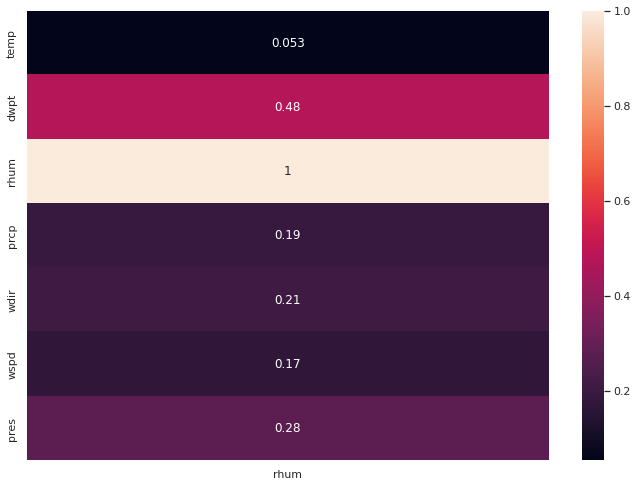

In [ ]:

corr = pd.DataFrame(weather_drp1.corr()[['rhum']].abs())
#visual representation
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, xticklabels=True, yticklabels=True, annot=True)
# weather_drp1

**Assigning "rhum" as target variable and splitting dataset**


In [ ]:
weather_y=weather_drp1.iloc[:,2]
weather_x=weather_drp1.drop(columns = 'rhum')

In [ ]:
## Train and Test Data ##
x_train,x_test,y_train,y_test=train_test_split(weather_x,weather_y,test_size=0.2,random_state=4)
#random_state gives the same value when assigned 0 or any int



**Importing Necessary Models and Error Models**


In [ ]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings

**Preparing Pipeline**

In [ ]:
## PipeLine ##
models_to_test = {
                  'decision tree': DecisionTreeRegressor(),
                  'random forest': RandomForestRegressor(),
                  'ML Regressor' : MLPRegressor()
                  }
def predict_and_return_error(y_predict, y_test):
    MAE = mean_absolute_error(y_test, y_predict)
    lin_mse = mean_squared_error(y_test, y_predict)
    lin_rmse = np.sqrt(lin_mse)
    r2 = r2_score(y_test, y_predict)
    warnings.simplefilter("ignore")

    return MAE, lin_mse, lin_rmse,r2




**Train **


In [ ]:
models_to_test['decision tree'].fit(x_train, y_train)
models_to_test['random forest'].fit(x_train, y_train)
models_to_test['ML Regressor'].fit(x_train, y_train)

y_predictrd = models_to_test['decision tree'].predict(x_train)
y_predictrr = models_to_test['random forest'].predict(x_train)
y_predictrml = models_to_test['ML Regressor'].predict(x_train)

yr = pd.DataFrame([y_predictrd,y_predictrr,y_predictrml ])


**Cross Validation Score**

In [ ]:
scoresdt = cross_validate(models_to_test['decision tree'], x_train, y_train, cv=5,scoring=('r2'))
scoresrf = cross_validate(models_to_test['random forest'], x_train, y_train, cv=5,scoring=('r2'))
scoresml = cross_validate(models_to_test['ML Regressor'], x_train, y_train, cv=5,scoring=('r2'))
r2dt = scoresdt['test_score'].mean()
r2rf = scoresrf['test_score'].mean()
r2ml = scoresml['test_score'].mean()

In [ ]:
print('Decision Tree:',r2dt,'Random Forest:',r2rf,'ML Regressor:',r2ml)

Decision Tree: 0.9892930577146076 Random Forest: 0.9962337958798357 ML Regressor: 0.9923249833252935


**Predict**

In [ ]:

y_predictd = models_to_test['decision tree'].predict(x_test)
y_predictr = models_to_test['random forest'].predict(x_test)
y_predictml = models_to_test['ML Regressor'].predict(x_test)
y = pd.DataFrame([y_predictd,y_predictr,y_predictml ])

**Accuracy Analysis**


In [ ]:
error = [] # test data error
er = []
trer = [] # train data error
trerror =[]

for i in range (0,len(y)):
  error = predict_and_return_error(y.iloc[i,:], y_test)
  er.append(error)
# print(er)

for i in range (0,len(y)):
  trerror = predict_and_return_error(yr.iloc[i,:], y_train)
  trer.append(trerror)
# print(trer)

  

name = ['Decision Tree','Random Forest', 'ML']

er = pd.DataFrame(er)
er['Name'] = name
er = er.rename(columns={0: 'MAE', 1: 'MSE', 2: 'RMSE', 3: 'R^2'})

print(er)

        MAE       MSE      RMSE       R^2           Name
0  0.618099  3.354582  1.831552  0.989898  Decision Tree
1  0.476397  1.102197  1.049856  0.996681  Random Forest
2  0.661824  0.689614  0.830430  0.997923             ML


**Visualization of Accuracy**


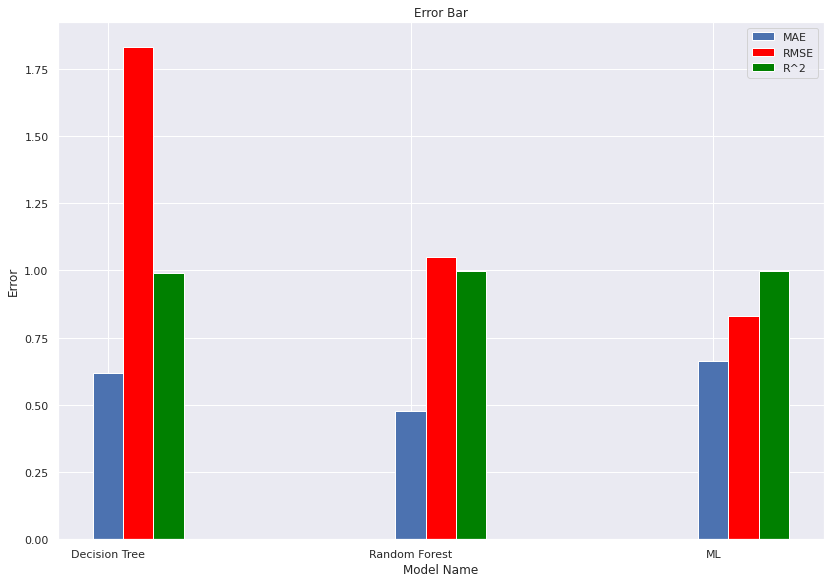

In [ ]:
model_name = er.iloc[:,4]
#error = er.iloc[0:3,0:4]
x = np.arange(len(model_name))
width = .2
plt.bar(x, er.iloc[:,0], width/2,label = 'MAE')
plt.bar(x+ width/2, er.iloc[:,2], width/2, label = 'RMSE',color = 'red')
plt.bar(x+ width/2*2, er.iloc[:,3], width/2, label = 'R^2',color = 'green')


# plt.bar( x + width/2*2 , er.iloc[:,2], width/2,label = 'RMSE')


plt.xticks(x,model_name)
# plt.yticks(x,model_name)
plt.xlabel("Model Name")
plt.ylabel("Error")
plt.title("Error Bar")
plt.tight_layout()
plt.legend()
plt.show()


**Out of all three random forest is giving the best result in two of the metrics. So we are choosing this one for hyper parameter tuning.**

**Fine Tuning**
**Random Forest**



In [ ]:
RF_model=RandomForestRegressor()

In [ ]:
parameters = {'n_estimators': [20,25,100,200],

'max_features': ['auto', 'sqrt'],

'max_depth': [16,18],

'min_samples_split': [2,3],

'min_samples_leaf':  [1,2,3],
              
'random_state': [1,10,42],
              
'bootstrap': [True, False]}

tuning_model_RF = RandomizedSearchCV(RF_model,parameters,scoring='neg_mean_squared_error', cv = 5)
tuning_model_RF.fit(x_train,y_train)
tuning_model_RF.best_params_

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

**Train, Predict and Accuracy Analysis Using Hyper Tuned Parameter**

In [ ]:
models_to_test_Hyper = { 'random forest Hyper': RandomForestRegressor(n_estimators= 100, bootstrap= True, max_depth=16,max_features='auto', min_samples_leaf=3,min_samples_split=2,random_state=42)
                  }

In [ ]:
models_to_test_Hyper['random forest Hyper'].fit(x_train, y_train)
y_predictrainrh = models_to_test_Hyper['random forest Hyper'].predict(x_train)
y_predictestrh = models_to_test_Hyper['random forest Hyper'].predict(x_test)


In [ ]:
yh = pd.DataFrame([y_predictestrh])
errorh = [] #for test data
erh = [] #for test data

for i in range (0,len(yh)):
  errorh = predict_and_return_error(yh.iloc[i,:], y_test)
  erh.append(errorh)
# print(er)

nameh = ['Random Forest']

erh = pd.DataFrame(erh)
erh['Name'] = nameh
erh = erh.rename(columns={0: 'MAE', 1: 'RMSE', 2: 'R^2'})

print(erh)

        MAE     RMSE       R^2         3           Name
0  0.580178  1.54905  1.244608  0.995335  Random Forest


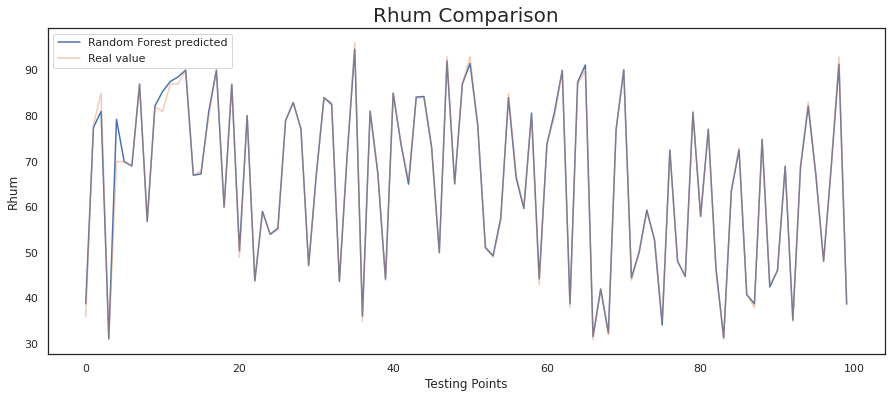

In [ ]:
print_range = 100
x_range = range(print_range)
sns.set_style('white')
fig = plt.subplots(figsize=(15, 6))

plt.plot(x_range, y_predictestrh[:print_range], label='Random Forest predicted')
plt.plot(x_range, y_test[:print_range], label='Real value',alpha=0.4)

plt.title(f'Rhum Comparison', fontsize=20)
plt.ylabel("Rhum")
plt.xlabel("Testing Points")
plt.legend()
# plt.tight_layout()
plt.show()
